# RNN Project, Coronavirus tweets NLP - Text Classification
- Petr Ptáček, PTA0054

## Popis datasetu a preprocessingu
- Dataset obsahuje tweety, které byly manuálně označeny mírou Sentimentu. V tomto datasetu existuje 5 tříd, které se budou predikovat (Velmi negativní, negativní, neutrální, positivní, velmi positivní). Jedná se tedy o multi label klasifikaci Sentimentu pomocí RNN sítě.
- Původně je dataset rozdělen na trénovací a testovací data. Já jsem si všechny data společně načetl a provedl preprocessing. Následně jsem si tyto data rozdělil v poměru 0.8:0.2 na trénovací a testovací pomocí stratifikace (Snažil jsem se zachovat vybalancované rozdělení tříd v datech).
- Celkový počet dat je 44955 záznamů, které obsahují samotný tweet, Sentiment, Uživatelské jméno, Display jméno uživatele, Lokaci, Čas. Jelikož budu provádět predikce sentimentu pouze z textu, tak si zanechám pouze samotný tweet a Sentiment - tedy náš label.
- O rozdělení tříd v datech se dá říct, že jsou rozloženy pomocí Normálního rozdělení. Tedy máme primárně hodně pozitivních, negativních a neutrálních tweetů. Dá se říct, že třídy jsou vybalancovány. Graf rozdělení lze vidět [zde](#distribution). Maximální rozdíl v počtu mezi jednotlivými třídami je 6000. Což se dalo předpokládat, jelikož se jedná o klasifikaci s více než 2 labely.
- Dle analýzy délky tweetů se dá říct, že nejdelší tweety jsou extrémně kladné nebo záporné. Nejkratší tweety jsou neutrální.
- Dále jsem provedl preprocessing, který se skládá z několika kroků, které jsem dále popsal v tomto notebooku. Primárně bylo nutné odstranit všechny twitter mentions (@Uzivatel1, @Uzivatel2, ...) a také URL adresy, které se ve velkém množství vyskytují v tweetech. Usoudil jsem, že tyto URL adresy nenesou primárně informaci o tom, zda je tweet pozitivní či ne. Dále jsem provedl úpravy jako převod na lowercase, odstranění interpunkce, odstranění jiných než ascii znaků, odstranění čísel a odstranění anglických stopwords.
- Nakonec jsem došel k číslu 47952 unikátních slov. Nejdelší tweety jsou o délce 41 slov. A nejčastější slova ve tweetech jsou: covid, coronavirus, food, prices, store, supermarket, ...
- Dále jsem musel enkodovat labely na čísla a ty následně převést na vektor pomocí one hot encoding.

## Import Knihoven

In [100]:
import os
import random
import itertools
# Pandas dataframes
import pandas as pd
# Numpy
import numpy as np 
# Tensorflow 2.10.0
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

# scikit-learn
import sklearn
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

# Graphing
import matplotlib
from matplotlib import pyplot as plt    
import seaborn as sns

In [81]:
import unicodedata, re, string
import nltk
from textblob import TextBlob

In [56]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pta0054/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [79]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pta0054/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [83]:
# just take a look on stopwords
print(nltk.corpus.stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [55]:
# check if gpu is ready to use
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Eneable
tf.config.run_functions_eagerly(True)

## Definované funkce

In [6]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [68]:
def remove_mentions(item):
    """Remove @Username from tweet """
    items_splitted = item.split()
    items_splitted_without_mentions = [x for x in items_splitted if not x.startswith("@")]
    return " ".join(items_splitted_without_mentions)

In [118]:
def remove_url(item):
    """Remove http://... because almost every tweet contain any redirection."""
    items_splitted = item.split()
    items_splitted_without_url = [x for x in items_splitted if not x.startswith("http")]
    return " ".join(items_splitted_without_url)

In [95]:
def fix_nt(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "n't" or words[i+1] == "nt":
            st_res.append(words[i]+("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    return st_res

In [82]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in nltk.corpus.stopwords.words("english"):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return tweet_blob.words

## Načtení dat a preprocessing

### Trénovací data a zároveň Testovací data

In [247]:
# Load train dataset
df_train = pd.read_csv("Corona_NLP_train.csv", encoding = "ISO-8859-1")
# Take only tweet and sentiment, because we are going to do sentiment analysis from tweets
df_train = df_train.loc[:, ["OriginalTweet", "Sentiment"]]

In [248]:
# Load test dataset
df_test = pd.read_csv("Corona_NLP_test.csv", encoding = "ISO-8859-1")
# Take only tweet and sentiment, because we are going to do sentiment analysis from tweets
df_test = df_test.loc[:, ["OriginalTweet", "Sentiment"]]

In [249]:
# Merge test and train dataset for common preprocessing
df_all = pd.concat([df_train, df_test], ignore_index=True)

In [250]:
# Size of train, test and all datasets.
print(f"Train: {df_train.shape[0]}, Test: {df_test.shape[0]}, Both: {df_all.shape[0]}")

Train: 41157, Test: 3798, Both: 44955


In [251]:
# Take a look at data
df_all.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [252]:
# How many classes we are going to predict?
print(f"Number of sentiment classes: {df_all.Sentiment.unique().shape[0]}")
print(f"The classes are: {df_all.Sentiment.unique()}")

Number of sentiment classes: 5
The classes are: ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


<a id='distribution'></a>

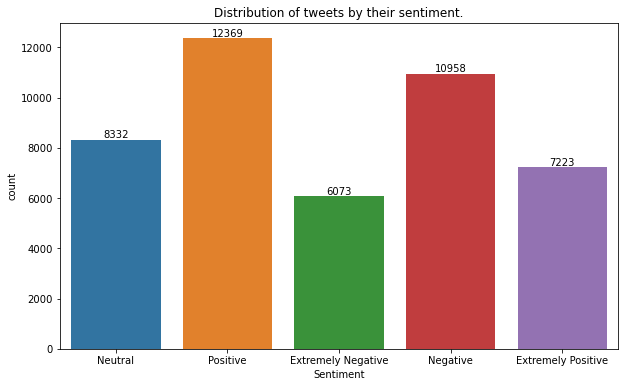

In [253]:
# How are the classes balanced?
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=df_all, x=df_all.Sentiment, ax=ax)
ax.set_title("Distribution of tweets by their sentiment.")

for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [254]:
# balance of the classes
neutral = round(df_all.loc[df_all.Sentiment == "Neutral"].shape[0] / df_all.shape[0], 2)
positive =  round(df_all.loc[df_all.Sentiment == "Positive"].shape[0] / df_all.shape[0], 2)
extremely_negative =  round(df_all.loc[df_all.Sentiment == "Extremely Negative"].shape[0] / df_all.shape[0], 2)
negative =  round(df_train.loc[df_all.Sentiment == "Negative"].shape[0] / df_all.shape[0], 2)
extremely_positive =  round(df_all.loc[df_all.Sentiment == "Extremely Positive"].shape[0] / df_all.shape[0], 2)
print(f"Classes are balanced like this:")
print(f"(Extremely Positive:Positive:Neutral:Negative:Extremely Negative)\n\
({extremely_positive}:{positive}:{neutral}:{negative}:{extremely_negative})\
        ")


Classes are balanced like this:
(Extremely Positive:Positive:Neutral:Negative:Extremely Negative)
(0.16:0.28:0.19:0.22:0.14)        


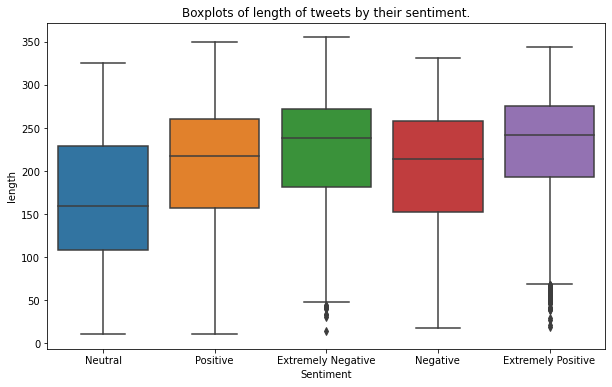

In [255]:
# check length of tweets
df_all["length"] = df_all.OriginalTweet.apply(lambda x: len(x))
# Plot boxplots for each class of sentiment
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x=df_all.Sentiment, y=df_all.length, data = df_all, ax=ax)
ax.set_title("Boxplots of length of tweets by their sentiment.")

plt.show()

In [256]:
# Take a detailed look on tweets
for x in df_all.loc[:10, 'OriginalTweet']:
    print(x)
    print('---------')

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
---------
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
---------
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
---------
My food stock is not the only one which is empty...

PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. 
Stay calm, stay safe.

#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
---------
Me, ready to go at supermarket during the #COVID19 outbreak.

Not because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please

In [257]:
# Remove @Username mentions
df_all["OriginalTweetNoMentions"] = df_all.OriginalTweet.apply(remove_mentions)
df_all.loc[:, ["OriginalTweet", "OriginalTweetNoMentions"]].head(5)

,OriginalTweet,OriginalTweetNoMentions
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,https://t.co/iFz9FAn2Pa and https://t.co/xX6gh...
1,advice Talk to your neighbours family to excha...,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...","Me, ready to go at supermarket during the #COV..."


In [258]:
# remove url address
df_all["OriginalTweetNoMentionsAndNoURL"] = df_all.OriginalTweetNoMentions.apply(remove_url)
df_all.loc[:, ["OriginalTweet", "OriginalTweetNoMentionsAndNoURL"]].head(5)

,OriginalTweet,OriginalTweetNoMentionsAndNoURL
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,and and
1,advice Talk to your neighbours family to excha...,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...","Me, ready to go at supermarket during the #COV..."


In [259]:
# Extract words from tweets
df_all['OriginalTweetWords'] = df_all['OriginalTweetNoMentionsAndNoURL'].apply(form_sentence)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/pta0054/anaconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5130, in <genexpr>
    ta.write(ta_index_to_write, out)  File "/home/pta0054/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


In [260]:
df_all.loc[:, ["OriginalTweet", "OriginalTweetWords"]].head()

,OriginalTweet,OriginalTweetWords
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,"[and, and]"
1,advice Talk to your neighbours family to excha...,"[advice, Talk, to, your, neighbours, family, t..."
2,Coronavirus Australia: Woolworths to give elde...,"[Coronavirus, Australia, Woolworths, to, give,..."
3,My food stock is not the only one which is emp...,"[My, food, stock, is, not, the, only, one, whi..."
4,"Me, ready to go at supermarket during the #COV...","[Me, ready, to, go, at, supermarket, during, t..."


In [261]:
# Normalize words
# - remove non ascii characters
# - change everything to lowercase
# - remove punctuation
# - remove numbers
# - remove stopwords
df_all["OriginalTweetWordsNormalized"] = df_all["OriginalTweetWords"].apply(normalize)
# Take a detailed look on tweets
for i in range(0, 10):
    x = df_all.iloc[i]
    print(x["OriginalTweetWordsNormalized"])
    print('---------')
#df_all.loc[:, ["OriginalTweet", "OriginalTweetWordsNormalized"]].head()

[]
---------
['advice', 'talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'phone', 'numbers', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order']
---------
['coronavirus', 'australia', 'woolworths', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'covid', 'outbreak']
---------
['food', 'stock', 'one', 'empty', 'please', 'nt', 'panic', 'enough', 'food', 'everyone', 'take', 'need', 'stay', 'calm', 'stay', 'safe', 'covidfrance', 'covid_', 'covid', 'coronavirus', 'confinement', 'confinementotal', 'confinementgeneral']
---------
['ready', 'go', 'supermarket', 'covid', 'outbreak', 'paranoid', 'food', 'stock', 'litteraly', 'empty', 'coronavirus', 'serious', 'thing', 'please', 'nt', 'panic', 'causes', 'shortage', 'coronavirusfrance', 'restezchezvous', 'stayathome', 'confinement']
---------
['news', 'regionas', 'first', 'confi

In [262]:
# Fix broken "do - n't" words
df_all['OriginalTweetWordsNormalized'] = df_all['OriginalTweetWordsNormalized'].apply(fix_nt)

In [263]:
# Now join words into string for each tweet
df_all['CleanText'] = df_all['OriginalTweetWordsNormalized'].apply(lambda x: " ".join(x))
df_all.loc[:, ["CleanText"]].head()

,CleanText
0,
1,advice talk neighbours family exchange phone n...
2,coronavirus australia woolworths give elderly ...
3,food stock one empty pleasen't panic enough fo...
4,ready go supermarket covid outbreak paranoid f...


In [264]:
# See most frequent words
# Tokenize every string and merge the token array into one big array
all_words = list(itertools.chain(*df_all.OriginalTweetWordsNormalized))

In [265]:
# Compute frequency of every token 
dist = nltk.FreqDist(all_words)

In [266]:
# The most common tokens are
dist

FreqDist({'covid': 17111, 'coronavirus': 15062, 'food': 8164, 'prices': 7896, 'store': 7659, 'supermarket': 7310, 'grocery': 7039, 'people': 6157, 'amp': 5749, 'consumer': 4621, ...})

In [267]:
# Number of unique words in train dataset
len(dist)

47952

In [268]:
# What is the longest tweet
max(df_all.OriginalTweetWordsNormalized.apply(len))

41

## Vlastní model RNN


In [164]:
embedding_dim = 128 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 50000 # Number of unique tokens in vocabulary
sequence_length = 41 # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df_all.CleanText.values)

In [165]:
# Split df_all to Train and Test df
X_train, X_test, y_train, y_test = train_test_split(df_all.CleanText, df_all.Sentiment, test_size=0.20, random_state=13, stratify=df_all.Sentiment)

In [166]:
# Split train df into Train and Validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

In [185]:
# Encode and One hot encode y_train, y_test, y_valid
label_encoder = sklearn.preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes= df_all.Sentiment.unique().shape[0])

y_test_encoded = label_encoder.transform(y_test)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes= df_all.Sentiment.unique().shape[0])

y_valid_encoded = label_encoder.transform(y_valid)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid_encoded, num_classes= df_all.Sentiment.unique().shape[0])

In [168]:
# Sizes of train, test and validation datasets
print(X_train.shape, X_test.shape, X_valid.shape)

(32367,) (8991,) (3597,)


In [169]:
# Balance of classes of sentiment
print('Train')
print(y_train.value_counts())
print('Test')
print(y_test.value_counts())
print("Validation")
print(y_valid.value_counts())


Train
Positive              8906
Negative              7889
Neutral               5999
Extremely Positive    5201
Extremely Negative    4372
Name: Sentiment, dtype: int64
Test
Positive              2474
Negative              2192
Neutral               1666
Extremely Positive    1444
Extremely Negative    1215
Name: Sentiment, dtype: int64
Validation
Positive              989
Negative              877
Neutral               667
Extremely Positive    578
Extremely Negative    486
Name: Sentiment, dtype: int64


In [170]:
# Take a look at vocabulary
print('Vocabulary example: ', vect_layer.get_vocabulary()[:10])
print('Vocabulary shape: ', len(vect_layer.get_vocabulary()))

Vocabulary example:  ['', '[UNK]', 'covid', 'coronavirus', 'food', 'prices', 'store', 'supermarket', 'grocery', 'people']
Vocabulary shape:  47895


### Experiment 1

In [210]:
# Build own RNN model
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
#x = tf.keras.layers.LSTM(256, activation='relu', return_sequences=True)(emb)
#x = tf.keras.layers.GRU(256, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True))(emb)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(df_all.Sentiment.unique().shape[0], 'softmax')(x)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=tf.keras.metrics.CategoricalAccuracy())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 41)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 41, 128)           6400000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 41, 512)          592896    
 nal)                                                            
                                                                 
 global_average_pooling1d_3   (None, 512)              0         
 (GlobalAveragePooling1D)                                        
                                                           

Epoch 1/20
506/506 [==============================] - 43s 86ms/step - loss: 1.0140 - categorical_accuracy: 0.5981 - val_loss: 0.8861 - val_categorical_accuracy: 0.6681
Epoch 2/20
506/506 [==============================] - 41s 81ms/step - loss: 0.7697 - categorical_accuracy: 0.7224 - val_loss: 0.8187 - val_categorical_accuracy: 0.6917
Epoch 3/20
506/506 [==============================] - 41s 82ms/step - loss: 0.6385 - categorical_accuracy: 0.7856 - val_loss: 0.8664 - val_categorical_accuracy: 0.6961
Epoch 4/20
506/506 [==============================] - 44s 86ms/step - loss: 0.5336 - categorical_accuracy: 0.8248 - val_loss: 0.8914 - val_categorical_accuracy: 0.6820
Epoch 5/20
506/506 [==============================] - 43s 86ms/step - loss: 0.4576 - categorical_accuracy: 0.8534 - val_loss: 0.9497 - val_categorical_accuracy: 0.6822
Epoch 6/20
506/506 [==============================] - 44s 88ms/step - loss: 0.3923 - categorical_accuracy: 0.8762 - val_loss: 1.0193 - val_categorical_accuracy:

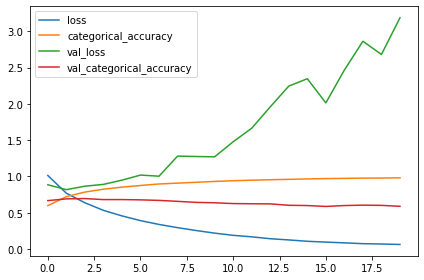

In [213]:
# Create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Train Model
batch_size = 64
epochs = 20

history = model.fit(X_train.values, y_train_one_hot, validation_data=(X_valid.values, y_valid_one_hot), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

### Experiment 2

In [214]:
# Build own RNN model
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(emb)
x = tf.keras.layers.GRU(64, activation='relu', return_sequences=True)(x)
#x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True))(emb)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, 'relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(32, 'relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output_layer = tf.keras.layers.Dense(df_all.Sentiment.unique().shape[0], 'softmax')(x)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=tf.keras.metrics.CategoricalAccuracy())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 41)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 41, 128)           6400000   
                                                                 
 lstm_2 (LSTM)               (None, 41, 64)            49408     
                                                                 
 gru_6 (GRU)                 (None, 41, 64)            24960     
                                                                 
 global_average_pooling1d_4   (None, 64)               0         
 (GlobalAveragePooling1D)                                  

Epoch 1/10
253/253 [==============================] - 148s 584ms/step - loss: 0.5282 - categorical_accuracy: 0.8397 - val_loss: 0.9872 - val_categorical_accuracy: 0.6761
Epoch 2/10
253/253 [==============================] - 138s 545ms/step - loss: 0.4642 - categorical_accuracy: 0.8613 - val_loss: 1.0130 - val_categorical_accuracy: 0.6731
Epoch 3/10
253/253 [==============================] - 138s 547ms/step - loss: 0.4072 - categorical_accuracy: 0.8786 - val_loss: 1.2019 - val_categorical_accuracy: 0.6653
Epoch 4/10
253/253 [==============================] - 140s 556ms/step - loss: 0.3619 - categorical_accuracy: 0.8947 - val_loss: 1.0988 - val_categorical_accuracy: 0.6689
Epoch 5/10
253/253 [==============================] - 150s 594ms/step - loss: 0.3145 - categorical_accuracy: 0.9078 - val_loss: 1.2910 - val_categorical_accuracy: 0.6633
Epoch 6/10
253/253 [==============================] - 142s 561ms/step - loss: 0.2794 - categorical_accuracy: 0.9180 - val_loss: 1.4184 - val_categoric

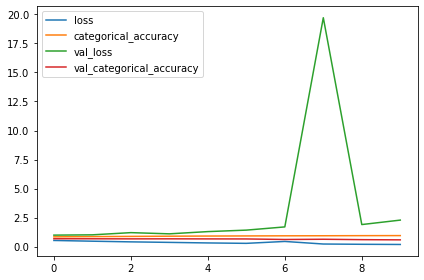

In [216]:
# Create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Train Model
batch_size = 128
epochs = 10

history = model.fit(X_train.values, y_train_one_hot, validation_data=(X_valid.values, y_valid_one_hot), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [217]:
# Load best setup
model.load_weights("weights.best.tf")
# Make predictions on test data
y_pred = model.predict(X_test).ravel()

281/281 [==============================] - 72s 255ms/step


In [232]:
# Evaluate model on test dataset
y_pred = y_pred.reshape((y_pred.shape[0] // 5 , 5))
right = 0
for index in range(0, y_pred.shape[0]):
    i_predicted = np.argmax(y_pred[index])
    i_real = np.argmax(y_test_one_hot[index])
    if i_predicted == i_real:
        right += 1;
accuracy = right / y_pred.shape[0]
print(f"Accuracy on test data: {round(accuracy,2) * 100} %")

Accuracy on test data: 66.0 %


### Experiment 3

In [239]:
# Build own RNN model
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
#x = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(emb)
#x = tf.keras.layers.GRU(64, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(emb)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(df_all.Sentiment.unique().shape[0], 'softmax')(x)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=tf.keras.metrics.CategoricalAccuracy())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 41)               0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 41, 128)           6400000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 41, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 41, 128)          74496     
 nal)                                                            
                                                           

Epoch 1/10
506/506 [==============================] - 57s 113ms/step - loss: 1.4197 - categorical_accuracy: 0.3697 - val_loss: 1.1121 - val_categorical_accuracy: 0.5549
Epoch 2/10
506/506 [==============================] - 58s 114ms/step - loss: 1.0402 - categorical_accuracy: 0.5996 - val_loss: 0.8975 - val_categorical_accuracy: 0.6575
Epoch 3/10
506/506 [==============================] - 57s 112ms/step - loss: 0.8399 - categorical_accuracy: 0.7117 - val_loss: 0.8968 - val_categorical_accuracy: 0.6694
Epoch 4/10
506/506 [==============================] - 57s 113ms/step - loss: 0.7227 - categorical_accuracy: 0.7642 - val_loss: 0.8763 - val_categorical_accuracy: 0.6964
Epoch 5/10
506/506 [==============================] - 56s 111ms/step - loss: 0.6394 - categorical_accuracy: 0.7982 - val_loss: 0.9436 - val_categorical_accuracy: 0.6900
Epoch 6/10
506/506 [==============================] - 56s 111ms/step - loss: 0.5621 - categorical_accuracy: 0.8274 - val_loss: 0.9553 - val_categorical_acc

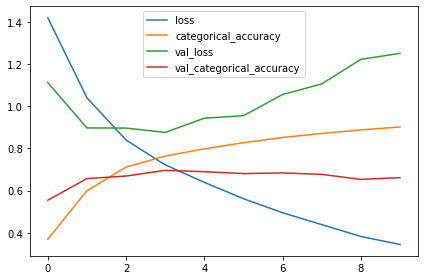

In [240]:
# Create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Train Model
batch_size = 64
epochs = 10

history = model.fit(X_train.values, y_train_one_hot, validation_data=(X_valid.values, y_valid_one_hot), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [241]:
# Load best setup
model.load_weights("weights.best.tf")

# Make predictions on test data
y_pred = model.predict(X_test).ravel()

# Evaluate model on test dataset
y_pred = y_pred.reshape((y_pred.shape[0] // 5 , 5))
right = 0
for index in range(0, y_pred.shape[0]):
    i_predicted = np.argmax(y_pred[index])
    i_real = np.argmax(y_test_one_hot[index])
    if i_predicted == i_real:
        right += 1;
accuracy = right / y_pred.shape[0]
print(f"Accuracy on test data: {round(accuracy,2) * 100} %")

281/281 [==============================] - 11s 38ms/step
Accuracy on test data: 70.0 %


### Shrnutí
- Pro tento problém jsem si vyzkoušel definovat 3 modely rekurentních neuronových sítí.
- Vyzkoušel jsem si použít jak vrstvu GRU, tak i LSTM. Obě v obousměrných verzích.
- Nejlepších výsledků jsem dosáhl pro experiment číslo 3 (70 % přesnost pro testovací data). Kdy jsem využil dvě obousměrné vrstvy LSTM a GRU. Obě po 64 neuronech. Klasifikační část se skládá ze dvou dense vrstev s relu aktivační funkcí a dropouty. Klasifikace v poslední vrstvě se realizovala pomocí softmax aktivační funkce.
- U všech experimentů jsem bojoval s problémem "Overfitting". Nakonec jsem došel k modelu použitému v experimentu číslo 3, kdy jsem omezil velikosti jednotlivých vrstev, přidal vyšší hodnoty pro dropout vrstvy a také jsem využil global average pooling vrstvu na výstup obou rekurentních vrstev.
- Poznámka: Loss funkci jsem volil CategoricalCrossentropy, jelikož jsem skutečné hodnoty y kódoval pomocí one hot encoding. A metriku jsem zvolil CategoricalAccuracy, jelikož jsem usoudil, že kategorie jsou vybalancovány (díky použití stratifikace).

## Transfer Learning embeding vrstvy

In [242]:
# Donwload glove pretrained embeding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

/bin/bash: /home/pta0054/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-04-08 21:59:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-08 21:59:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-08 21:59:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HT

In [243]:
# Choose number of dimensions for glove. I Will go with 100d.
path_to_glove_file = 'glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [269]:
# get vocabulary from vectorizer and integer indexes
embedding_dim = 100 # Embedding dimension -> GloVe 100
vocab_size = 50000 # Number of unique tokens in vocabulary
sequence_length = 40 # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df_all.CleanText.values)

voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

/home/pta0054/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [273]:
# Map int indices to the embedding vectors and save the mapping to the matrix
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29028 words (18867 misses)


### Model z experimentu č. 3

In [275]:
# Now use the Glove Embedding in the embedding layer 
# Build own RNN model
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = tf.keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
#x = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(emb)
#x = tf.keras.layers.GRU(64, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(emb)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(df_all.Sentiment.unique().shape[0], 'softmax')(x)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=tf.keras.metrics.CategoricalAccuracy())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 40)               0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 40, 100)           4789700   
                                                                 
 bidirectional_9 (Bidirectio  (None, 40, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 40, 128)          74496     
 onal)                                                           
                                                           

Epoch 1/10
506/506 [==============================] - 91s 180ms/step - loss: 0.8182 - categorical_accuracy: 0.7015 - val_loss: 0.9007 - val_categorical_accuracy: 0.6617
Epoch 2/10
506/506 [==============================] - 90s 179ms/step - loss: 0.7801 - categorical_accuracy: 0.7180 - val_loss: 0.9029 - val_categorical_accuracy: 0.6580
Epoch 3/10
506/506 [==============================] - 97s 191ms/step - loss: 0.7552 - categorical_accuracy: 0.7294 - val_loss: 0.9167 - val_categorical_accuracy: 0.6636
Epoch 4/10
506/506 [==============================] - 103s 204ms/step - loss: 0.7121 - categorical_accuracy: 0.7459 - val_loss: 0.9808 - val_categorical_accuracy: 0.6722
Epoch 5/10
506/506 [==============================] - 109s 215ms/step - loss: 0.6843 - categorical_accuracy: 0.7618 - val_loss: 0.9387 - val_categorical_accuracy: 0.6678
Epoch 6/10
506/506 [==============================] - 97s 193ms/step - loss: 0.6544 - categorical_accuracy: 0.7697 - val_loss: 0.9834 - val_categorical_a

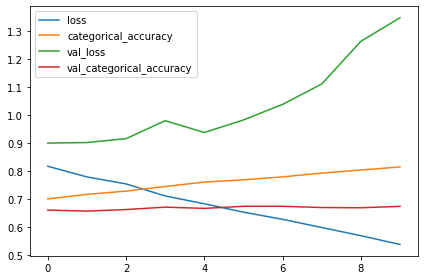

In [278]:
# Create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Train Model
batch_size = 64
epochs = 10

history = model.fit(X_train.values, y_train_one_hot, validation_data=(X_valid.values, y_valid_one_hot), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [279]:
# Load best setup
model.load_weights("weights.best.tf")

# Make predictions on test data
y_pred = model.predict(X_test).ravel()

# Evaluate model on test dataset
y_pred = y_pred.reshape((y_pred.shape[0] // 5 , 5))
right = 0
for index in range(0, y_pred.shape[0]):
    i_predicted = np.argmax(y_pred[index])
    i_real = np.argmax(y_test_one_hot[index])
    if i_predicted == i_real:
        right += 1;
accuracy = right / y_pred.shape[0]
print(f"Accuracy on test data: {round(accuracy,2) * 100} %")

281/281 [==============================] - 11s 38ms/step
Accuracy on test data: 67.0 %


In [280]:
# FINE TUNING
emb.trainable = True

In [282]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-5), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=tf.keras.metrics.CategoricalAccuracy())

Epoch 1/10
1012/1012 [==============================] - 271s 268ms/step - loss: 0.6980 - categorical_accuracy: 0.7577 - val_loss: 0.9061 - val_categorical_accuracy: 0.6825
Epoch 2/10
1012/1012 [==============================] - 279s 275ms/step - loss: 0.6955 - categorical_accuracy: 0.7594 - val_loss: 0.9073 - val_categorical_accuracy: 0.6820
Epoch 3/10
1012/1012 [==============================] - 276s 272ms/step - loss: 0.6958 - categorical_accuracy: 0.7568 - val_loss: 0.9084 - val_categorical_accuracy: 0.6817
Epoch 4/10
1012/1012 [==============================] - 278s 275ms/step - loss: 0.6949 - categorical_accuracy: 0.7577 - val_loss: 0.9092 - val_categorical_accuracy: 0.6811
Epoch 5/10
1012/1012 [==============================] - 265s 262ms/step - loss: 0.6924 - categorical_accuracy: 0.7586 - val_loss: 0.9108 - val_categorical_accuracy: 0.6806
Epoch 6/10
1012/1012 [==============================] - 283s 279ms/step - loss: 0.6932 - categorical_accuracy: 0.7607 - val_loss: 0.9122 - v

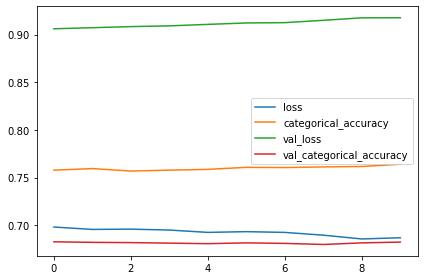

In [286]:
# Create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Train Model
batch_size = 32
epochs = 10

history = model.fit(X_train.values, y_train_one_hot, validation_data=(X_valid.values, y_valid_one_hot), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [287]:
# Load best setup
model.load_weights("weights.best.tf")

# Make predictions on test data
y_pred = model.predict(X_test).ravel()

# Evaluate model on test dataset
y_pred = y_pred.reshape((y_pred.shape[0] // 5 , 5))
right = 0
for index in range(0, y_pred.shape[0]):
    i_predicted = np.argmax(y_pred[index])
    i_real = np.argmax(y_test_one_hot[index])
    if i_predicted == i_real:
        right += 1;
accuracy = right / y_pred.shape[0]
print(f"Accuracy on test data: {round(accuracy,2) * 100} %")

281/281 [==============================] - 33s 119ms/step
Accuracy on test data: 68.0 %


### Shrnutí
- Je vidět, že za pomocí Glove a Transfer learningu se dá rozhodně dosáhnout stejného výsledku, jakého jsem dosáhl s vlastním embedingem.
- Jakmile jsem si zkoušel Fine tuning s velmi malým učícím koeficientem, tak šlo vidět, že je zde rozhodně prostor pro lepší naučení. Tedy overfitting se rapidně nezvyšoval. Bylo lepší snížit batch size, aby se model více učil. Doba učení se sice protáhla, ale opravdu se povedlo lépe model naučit.